## https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
を日本語訳していった版

In [3]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

## 特徴量エンジニアリング、データの前処理
Now we will proceed much like how most kernels in general are structured,and that is to first explore the data on hand, identify possible feature engineering opportunities as well as numerically encode any categorical features
ほとんどのカーネルがどのように構造化されているか、それは最初にデータを展開し、特徴量エンジニアリングする機会を特定し、任意のカテゴリの機能を数値的にエンコードすることです。

In [4]:
# Load in the train and test datasets
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Well it is no surprise that our task is to somehow extract the information out of the categorical variables

### Feature Engineering

Here, credit must be extended to Sina's very comprehensive and well-thought out notebook for the feature engineering ideas so please check out his work

我々の仕事は何とかカテゴリ変数から情報を抽出することです。
### 特徴量エンジニアリング
ここでは、特徴量エンジニアリングのアイデアの為にSinaの非常に良く考えられたnotebookがあるため下記をチェックしてください。

Titanic Best Working Classfier : by Sina


In [6]:
full_data = [train, test]
# Some features of my own that I have added in
# 私が追加したいくつかの特徴
# Gives the length of the name
# 名前の長さを設定する。
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
# 乗客がTitanic内に客室をもっていたかという特徴量
train['Has_Cabin'] = train["Cabin"].apply(lambda x:0 if type(x) == float else 1)
test['Has_Cabin'] = train["Cabin"].apply(lambda x:0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
# Sinaによる特徴量エンジニアリング 手法
# SibSp(兄弟)とParch(両親)の組み合わせとして新しい特徴 FamilySize(家族の人数)を作成する。
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1 #最後の1は本人
# Create new feature IsAlone from FamilySize
# 新しい特徴「IsAlone」をFamilySizeから作成する。
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
# Embarked(乗船港)のNULLを全て削除(一旦'S'で埋める)
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
# Fare(料金)列も同様にNULLを中央値で埋める。そしてCategoricalFare 料金ランクという特徴料を作成する。
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4) #qcut 4等分
# Create a New feature CategoricalAge
# 新しい特徴「年齢カテゴリ」を作成
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5) #ざっくり5分割
# Define function to extract titles from passenger names
# 乗客名から敬称を取得する関数を定義
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
# 新しい特徴としてTitle:敬称を作成する。（乗客名に敬称が含まれているか)
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
# 一般的でない敬称を全て1つのグループ"Rare"に入れる
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

#文字表現を数値に置き換え
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;


In [7]:
# Feature selection
# 特徴量選別
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

All right so now having cleaned the features and extracted relevant information and dropped the categorical columns our features should now all be numeric, a format suitable to feed into our Machine Learning models. However before we proceed let us generate some simple correlation and distribution plots of our transformed dataset to observe ho

前処理が完了したことで不要なカテゴリ変数は削除され全ての特徴は数値化されました。これは我々の機械学習モデルにフィードするのに適したフォーマットです。しかし、モデルを作成する前に、我々の変換されたデータセットのいくつかの単純な相関および分布プロットを生成します。

## Visualisations (可視化)


In [9]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


### Pearson Correlation Heatmap

let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilise the Seaborn plotting package which allows us to plot heatmaps very conveniently as follows

### ピアソン相関ヒートマップ

関連する1つの特徴量が次の特徴料とどのように関連しているかを確認するため特徴量の相関プロットを生成してみましょう。
そうするため Seaborn プロットパッケージを利用すると次のようにヒートマップを便利にプロットすることができます。

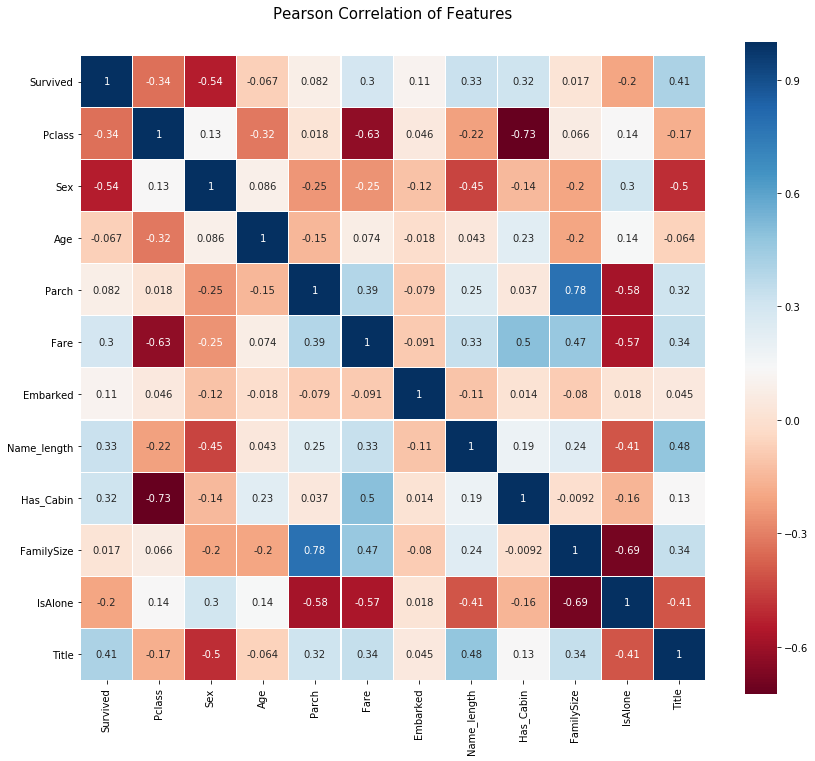

In [10]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

### Takeaway from the Plots

One thing that that the Pearson Correlation plot can tell us is that there are not too many features strongly correlated with one another. This is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique information. Here are two most correlated features are that of Family size and Parch (Parents and Children). I'll still leave both features in for the purposes of this exercise.

### Plotからの除去
Pearson Correlationプロットが教えてくれることの1つは、あまりにも多くの特徴が互いに強く相関していないということです。
これは、学習モデルにこれらの特徴量を追加するという観点からは優れています。
これは、トレーニングセットに冗長または余分なデータがないことを意味し、各特徴量に固有の情報があることを嬉しく思います。
FamilySizeとParch(両親)には強い相関があるがまだこの演習の目的の為に両方の特徴量を残します。

### PairPlots
Finally let us generate some pairplots to observe the distribution of data from one feature to the other. Once again we use Seaborn to help us.
最後にある特徴量から別の特徴量へのデータ分布を見るためのペアプロットを生成します。再びSeabornを使用します。

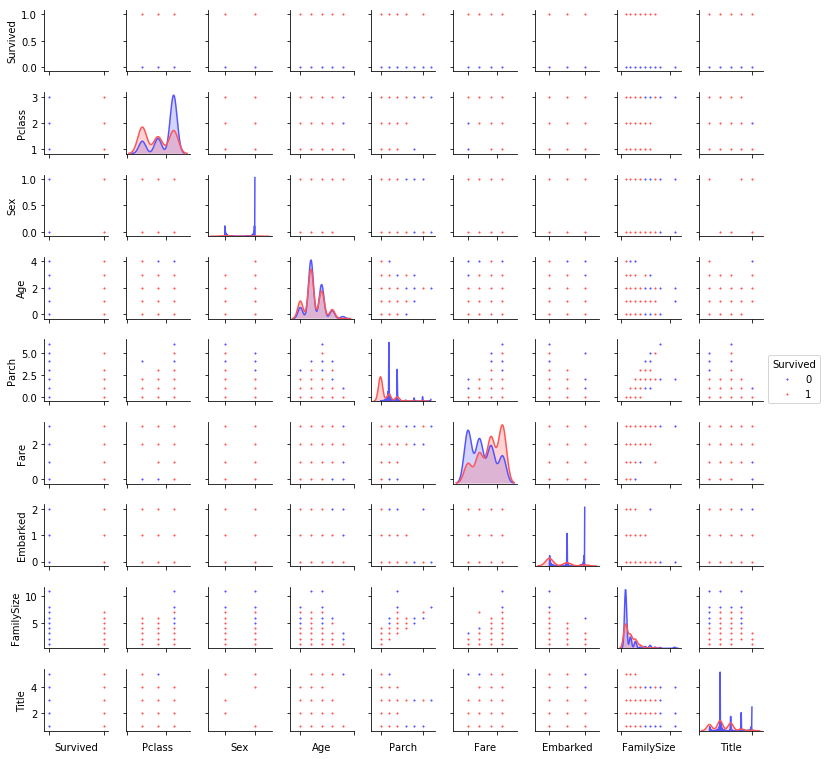

In [11]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

## Ensembling & Stacking models

Finally after that brief whirlwind detour with regards to feature engineering and formatting, we finally arrive at the meat and gist of the this notebook.
Creating a Stacking ensemble!

## アンサンブル & スタッキング　モデル
最後に特徴量エンジニアリングについての簡単なbrief whirlwind detourの後
私達は最終的にこのノートの要点に到着する。スタッキングアンサンブルを作ることです。

### Helpers via Python Classes
Here we invoke the use of Python's classes to help make it more convenient for us. For any newcomers to programming, one normally hears Classes being used in conjunction with Object-Oriented Programming (OOP). In short, a class helps to extend some code/program for creating objects (variables for old-school peeps) as well as to implement functions and methods specific to that class.

In the section of code below, we essentially write a class SklearnHelper that allows one to extend the inbuilt methods (such as train, predict and fit) common to all the Sklearn classifiers. Therefore this cuts out redundancy as won't need to write the same methods five times if we wanted to invoke five different classifiers.

### Python ClassesによるHelpers
ここではPythonのクラスを利用してより便利になるようにします。プログラムの初学者にとっては通常クラスはオブジェクト指向プログラミングと併用されます。要するにクラスはオブジェクトを作成するためのコード/プログラムを拡張子、そのクラスに固有の関数とメソッドを実装するのに役立ちます。

以下のコードのセクションではビルドされたメソッド(train,predict,fit等)を拡張できるSklearnHelperクラスを記述します。
したがって5つの異なる分類氏を呼び出すときに同じメソッドを5回書く必要が無く冗長性を排除できます。

In [12]:
# Some useful parameters which will come in handy later on　後で使う便利なパラメータ
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility　再現性の為のパラメータ
NFOLDS = 5 # set folds for out-of-fold prediction　折り畳み外予測用に折り畳み数を設定

#KFold(n,k) n個の標本をk個に分割、1バッチをテスト用、残りをトレーニング用に使う。
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier SKlearnクラスの拡張
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer


Bear with me for those who already know this but for people who have not created classes or objects in Python before, let me explain what the code given above does. In creating my base classifiers, I will only use the models already present in the Sklearn library and therefore only extend the class for that.
Pythonでクラスやオブジェクトを作成していない人の為に上記のコードが何をしているのかを説明しましょう。
基本分類機を作成する際はSklearnライブラリに既に存在するモデルのみを使用しますので、そのクラスを拡張してください。

def init : Python standard for invoking the default constructor for the class. This means that when you want to create an object (classifier), you have to give it the parameters of clf (what sklearn classifier you want), seed (random seed) and params (parameters for the classifiers).

def init : クラスのコンストラクタを呼び出すためのPython標準。これはオブジェクト(クラス)を作成する場合シード、paramsなどのパラメータを与える必要があることを意味します。

The rest of the code are simply methods of the class which simply call the corresponding methods already existing within the sklearn classifiers. Essentially, we have created a wrapper class to extend the various Sklearn classifiers so that this should help us reduce having to write the same code over and over when we implement multiple learners to our stacker.

残りのコードは単にクラスのメソッドであり、単にSklearnクラス内に既に存在する対応するメソッドを呼び出すだけです。
様々なSklearn Classifiersを拡張するためのラッパークラスを作成しました。これにより複数の学習器をスタッカーに実装するときに同じコードを何度も書く必要を減らすのに役立ちます。

### Out-of-Fold Predictions
Now as alluded to above in the introductory section, stacking uses predictions of base classifiers as input for training to a second-level model. However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

上の入門セクションで言及したようにスタッキングでは第2レベルモデルへのトレーニングの入力として基本分類子の予測が使用されます。
しかし、完全なトレーニングデータで基本モデルを訓練するだけでは、完全なテストセットで予測を生成してから、第2レベルの訓練のためにこれらを出力することはできません。
これにより、既にベースモデルの予測がテストセットを「見た」状態にあるため、これらの予測を供給する際にオーバーフィットするリスクがあります。

In [13]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating our Base First-Level Models
基底となる第1レベルモデルの生成
So now let us prepare five learning models as our first level classification. These models can all be conveniently invoked via the Sklearn library and are listed as follows:

それでは、最初のレベルの分類として5つの学習モデルを用意しましょう。
これらのモデルは、Sklearnライブラリを介してすべて便利に呼び出すことができ、以下のようにリストされています。

Random Forest classifier　  :ランダムフォレスト

Extra Trees classifier      :ExtraTrees

AdaBoost classifer          :Ada Boost

Gradient Boosting classifer :GradientBoosting

Support Vector Machine      :サポートベクタマシン

### Parameters

Just a quick summary of the parameters that we will be listing here for completeness,
リストアップするパラメータの簡単な要約

__n_jobs__ : Number of cores used for the training process. If set to -1, all cores are used.
トレーニングプロセスに使用されるコアの数。 -1に設定すると、すべてのコアが使用されます。

__n_estimators__ : Number of classification trees in your learning model ( set to 10 per default)
学習モデルの分類ツリーの数（デフォルトで10に設定）

__max_depth__ : Maximum depth of tree, or how much a node should be expanded. Beware if set to too high a number would run the risk of overfitting as one would be growing the tree too deep
ツリーの最大深度、またはノードをどれだけ拡張するか。あまりにも高い数に設定されていると、あまりにも深刻なツリーを成長させるので、オーバーフィットのリスクを冒すことに注意してください

__verbose__ : Controls whether you want to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.
学習プロセス中にテキストを出力するかどうかを制御します。 0の値はすべてのテキストを抑制し、3の値は各繰り返しでツリー学習プロセスを出力します。

Please check out the full description via the official Sklearn website. There you will find that there are a whole host of other useful parameters that you can play around with.

Sklearnの公式ウェブサイトから詳しい説明をご覧ください。そこには、あなたが周りに遊ぶことができる他の有用なパラメータの完全なホストがあることがわかります。


In [14]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}
# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

Furthermore, since having mentioned about Objects and classes within the OOP framework, let us now create 5 objects that represent our 5 learning models via our Helper Sklearn Class we defined earlier.

さらに、OOPフレームワーク内のオブジェクトとクラスについて言及したので、今度は先に定義したHelper Sklearnクラスを介して、5つの学習モデルを表す5つのオブジェクトを作成しましょう。

In [15]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

### Creating NumPy arrays out of our train and test sets
Numpy配列の生成

Great. Having prepared our first layer base models as such, we can now ready the training and test test data for input into our classifiers by generating NumPy arrays out of their original dataframes as follows:
最初の層の基本モデルを準備したら、次のように元のデータフレームからNumPy配列を生成することで、分類子への入力用のトレーニングとテストのテストデータを準備することができます。

In [16]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

### Output of the First level Predictions

We now feed the training and test data into our 5 base classifiers and use the Out-of-Fold prediction function we defined earlier to generate our first level predictions. Allow a handful of minutes for the chunk of code below to run.
トレーニングとテストのデータを5つの基本分類器に送り、前に定義したアウト・オブ・フォルド予測関数を使用して、最初のレベルの予測を生成します。以下のコードを実行するには、少し時間が必要です

In [17]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


### Feature importances generated from the different classifiers

Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models and that is to output the importances of the various features in the training and test sets with one very simple line of code.
今、最初のレベルの分類器を学んだので、Sklearnモデルの非常に素晴らしい機能を利用できます。
それは、非常に簡単なコード行でトレーニングとテストセットのさまざまな機能の重要度を出力することです。

As per the Sklearn documentation, most of the classifiers are built in with an attribute which returns feature importances by simply typing in .featureimportances. Therefore we will invoke this very useful attribute via our function earli and plot the feature importances as such


Sklearnのドキュメントによると、ほとんどの分類器は、単にfeature_importancesを入力するだけで特徴量の重要性を返す属性で組み込まれています。
したがって、関数earliを使用してこの非常に有用な属性を呼び出すと、そのような機能のimportancesをプロットします



In [20]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.12648906 0.19839068 0.03129271 0.02157182 0.07093469 0.0234352
 0.10985695 0.06512818 0.0660405  0.01389899 0.27296123]
[0.12141452 0.38077824 0.02977426 0.0172227  0.05688218 0.02833592
 0.04717704 0.08316042 0.04322606 0.02200512 0.17002355]
[0.032 0.014 0.018 0.066 0.034 0.008 0.688 0.014 0.054 0.002 0.07 ]
[0.07448817 0.02581703 0.11377961 0.03343331 0.09553112 0.04830681
 0.39273977 0.02107869 0.08149994 0.02404541 0.08928014]


So I have not yet figured out how to assign and store the feature importances outright. Therefore I'll print out the values from the code above and then simply copy and paste into Python lists as below (sorry for the lousy hack)
私はまだどのように機能の割り当てを割り当てて格納するかを考え出していない
したがって、私は上記のコードから値を出力して、単に以下のようにPythonのリストにコピーして貼り付けます。（ひどいハックには申し訳ありません）

In [21]:
rf_features = [0.12648906,0.19839068,0.03129271,0.02157182,0.07093469,0.0234352,0.10985695,0.06512818,0.0660405,0.01389899,0.27296123]
et_features = [0.12141452,0.38077824,0.02977426,0.0172227,0.05688218,0.02833592,0.04717704,0.08316042,0.04322606,0.02200512,0.17002355]
ada_features = [0.032,0.014,0.018,0.066,0.034,0.008,0.688,0.014,0.054,0.002,0.07]
gb_features = [0.07448817,0.02581703,0.11377961,0.03343331,0.09553112,0.04830681,0.39273977,0.02107869,0.08149994,0.02404541,0.08928014]

Create a dataframe from the lists containing the feature importance data for easy plotting via the Plotly package.

Plotlyパッケージを使用して簡単にプロットできるように、機能重要度データを含むリストからデータフレームを作成します。

In [22]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

### Interactive feature importances via Plotly scatterplots

I'll use the interactive Plotly package at this juncture to visualise the feature importances values of the different classifiers via a plotly scatter plot by calling "Scatter" as follows:

ここでは、インタラクティブPlotlyパッケージを使用して、次のように「Scatter」を呼び出すことによってプロットされた散布図を使用して、さまざまな分類子の特徴量の値を視覚化します。

In [23]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

Now let us calculate the mean of all the feature importances and store it as a new column in the feature importance dataframe.

次に、すべてのフィーチャの重要度を計算し、フィーチャ重要度データフレームに新しい列として保存します。

In [24]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.032,0.121415,0.074488,0.126489,Pclass,0.088598
1,0.014,0.380778,0.025817,0.198391,Sex,0.154746
2,0.018,0.029774,0.113780,0.031293,Age,0.048212


### Plotly Barplot of Average Feature Importances

Having obtained the mean feature importance across all our classifiers, we can plot them into a Plotly bar plot as follows:

すべての分類器で平均的なフィーチャの重要度が得られたら、それらを次のようにPlotly棒グラフにプロットできます。


In [25]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

## Second-Level Predictions from the First-level Output
### First-level output as new features
Having now obtained our first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier. As per the code below, we are therefore having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.


最初のレベルの予測を取得したので、次の分類子の訓練データとして使用するための新しいセットのフィーチャを構築することが基本的に考えられます。
下のコードでは、新しい列として以前の分類子の第1レベルの予測を行い、次の分類子を訓練します。

In [26]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [27]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

There have been quite a few articles and Kaggle competition winner stories about the merits of having trained models that are more uncorrelated with one another producing better scores.

お互いに無関係で、より良いスコアを出す訓練されたモデルを持つメリットについて、かなりの数の記事とKaggleのコンテストの勝者の話がありました。


In [28]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

Having now concatenated and joined both the first-level train and test predictions as x_train and x_test, we can now fit a second-level learning model.

x_trainとx_testのような第1レベルの列車とテストの予測を連結して結合したので、今度は第2レベルの学習モデルに適合させることができます。

## Second level learning model via XGBoost
Here we choose the eXtremely famous library for boosted tree learning model, XGBoost. It was built to optimize large-scale boosted tree algorithms. For further information about the algorithm, check out the official documentation.


ここでは、ブーストツリー学習モデルXGBoostのための非常に有名なライブラリを選択します。
これは、大規模なブーストツリーアルゴリズムを最適化するために構築されました。アルゴリズムの詳細については、公式のドキュメントを参照してください。


Anyways, we call an XGBClassifier and fit it to the first-level train and target data and use the learned model to predict the test data as follows:

私たちはXGBClassifierを呼び出して、それを第1レベルの列車とターゲットデータに適合させ、学習モデルを使用して次のようにテストデータを予測します。


In [29]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

Just a quick run down of the XGBoost parameters used in the model:

__max_depth__ : How deep you want to grow your tree. Beware if set to too high a number might run the risk of overfitting.

__gamma__ : minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.

__eta__ : step size shrinkage used in each boosting step to prevent overfitting

Producing the Submission file

Finally having trained and fit all our first-level and second-level models, we can now output the predictions into the proper format for submission to the Titanic competition as follows:

In [30]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

Steps for Further Improvement

As a closing remark it must be noted that the steps taken above just show a very simple way of producing an ensemble stacker. You hear of ensembles created at the highest level of Kaggle competitions which involves monstrous combinations of stacked classifiers as well as levels of stacking which go to more than 2 levels.

Some additional steps that may be taken to improve one's score could be:

Implementing a good cross-validation strategy in training the models to find optimal parameter values
Introduce a greater variety of base models for learning. The more uncorrelated the results, the better the final score.
Conclusion
I have this notebook has been helpful somewhat in introducing a working script for stacking learning models. Again credit must be extended to Faron and Sina.

For other excellent material on stacking or ensembling in general, refer to the de-facto Must read article on the website MLWave: Kaggle Ensembling Guide.